# Часові ряди

## Мета роботи:
Навчитися аналізувати часові ряди, визначати їх компоненти, будувати прогностичні моделі та оцінювати їх точність.


### Вибір фактору для прогнозу:

На основі набору даних з першої чи другої лабораторної роботи виберіть один довільний фактор (показник), який потрібно прогнозувати.

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from arch import arch_model as arch_model_build
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

### Побудова графіка вибраного фактору:

Використовуючи бібліотеки Python (наприклад, matplotlib або seaborn), побудуйте графік обраного фактору.

In [132]:
DAYS_IN_MONTH = 30
HOURS_IN_DAY = 24
DAYS_IN_WEEK = 7

DATASETS = 'datasets/'

In [133]:
female_births_df = pd.read_csv(DATASETS + "female-births.csv")
female_births_df["Date"] = pd.to_datetime(female_births_df["Date"])

female_births_df

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [134]:
female_births_df_total = len(female_births_df)

female_births_df_total

365

In [135]:
dates = female_births_df["Date"].dt.dayofyear.to_numpy()
births = female_births_df[["Births"]].to_numpy().flatten()

female_births_df_offset = female_births_df_total - 30

dates_train = dates[:female_births_df_offset]
dates_test = dates[female_births_df_offset:]
births_train = births[:female_births_df_offset]
births_test = births[female_births_df_offset:]

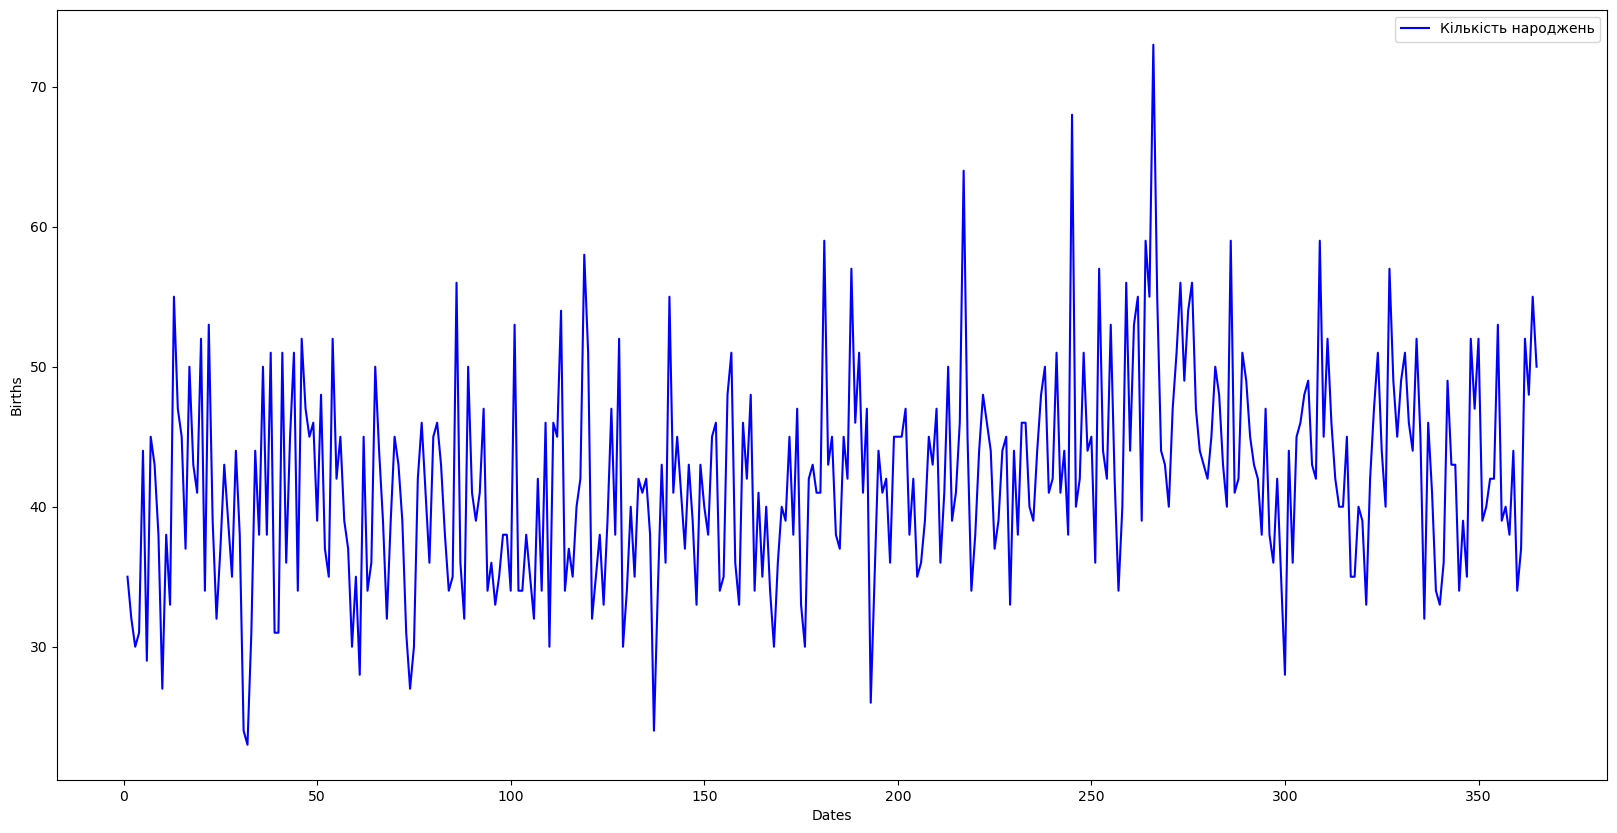

In [136]:
plt.figure(figsize=(20, 10))
plt.plot(dates, births, color='blue', label='Кількість народжень')
plt.xlabel('Dates')
plt.ylabel('Births')
plt.legend()
plt.show()

### Розклад фактору на компоненти:

- Виконайте декомпозицію обраного фактору на трендову, сезонну та випадкову компоненти за допомогою бібліотеки statsmodels.
- Побудуйте окремі графіки для кожної з компонент.

In [137]:
def draw_seasonal_decompose(period):
      result = seasonal_decompose(births, model='additive', period=period)
      result.plot()

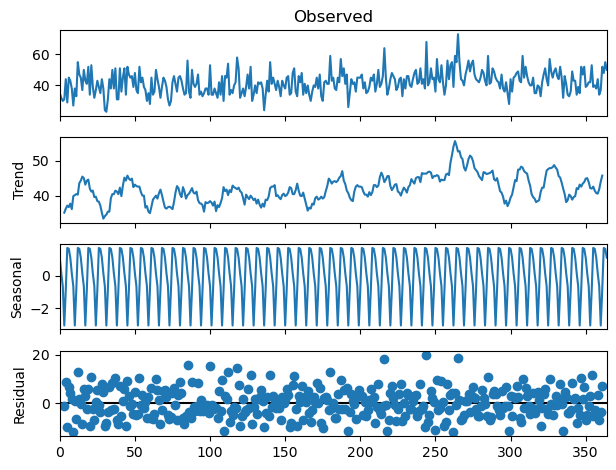

In [138]:
draw_seasonal_decompose(DAYS_IN_WEEK)

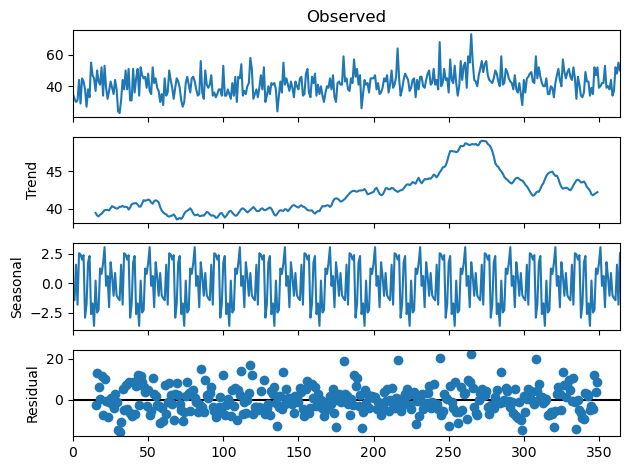

In [139]:
draw_seasonal_decompose(DAYS_IN_MONTH)

In [145]:
def draw_stl_prediction(period):
    stl = STL(births, period=period)
    result = stl.fit()
    result.plot()
    plt.show()

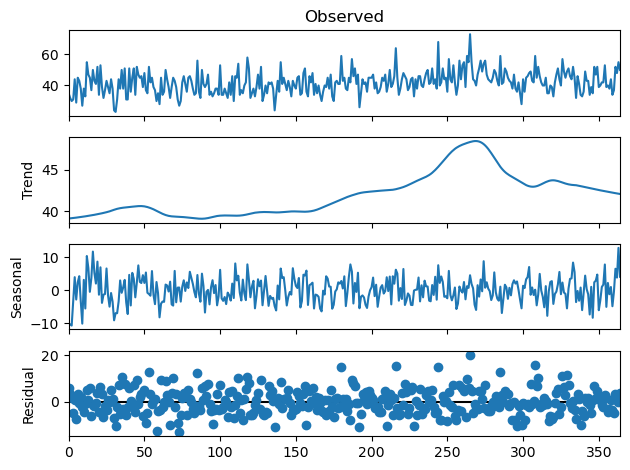

In [146]:
draw_stl_prediction(DAYS_IN_MONTH)

### Побудова графіків ACF та PACF:

- Використовуючи бібліотеку statsmodels, побудуйте графіки автокореляційної функції (ACF) та часткової автокореляційної функції (PACF) для вибраного фактору.

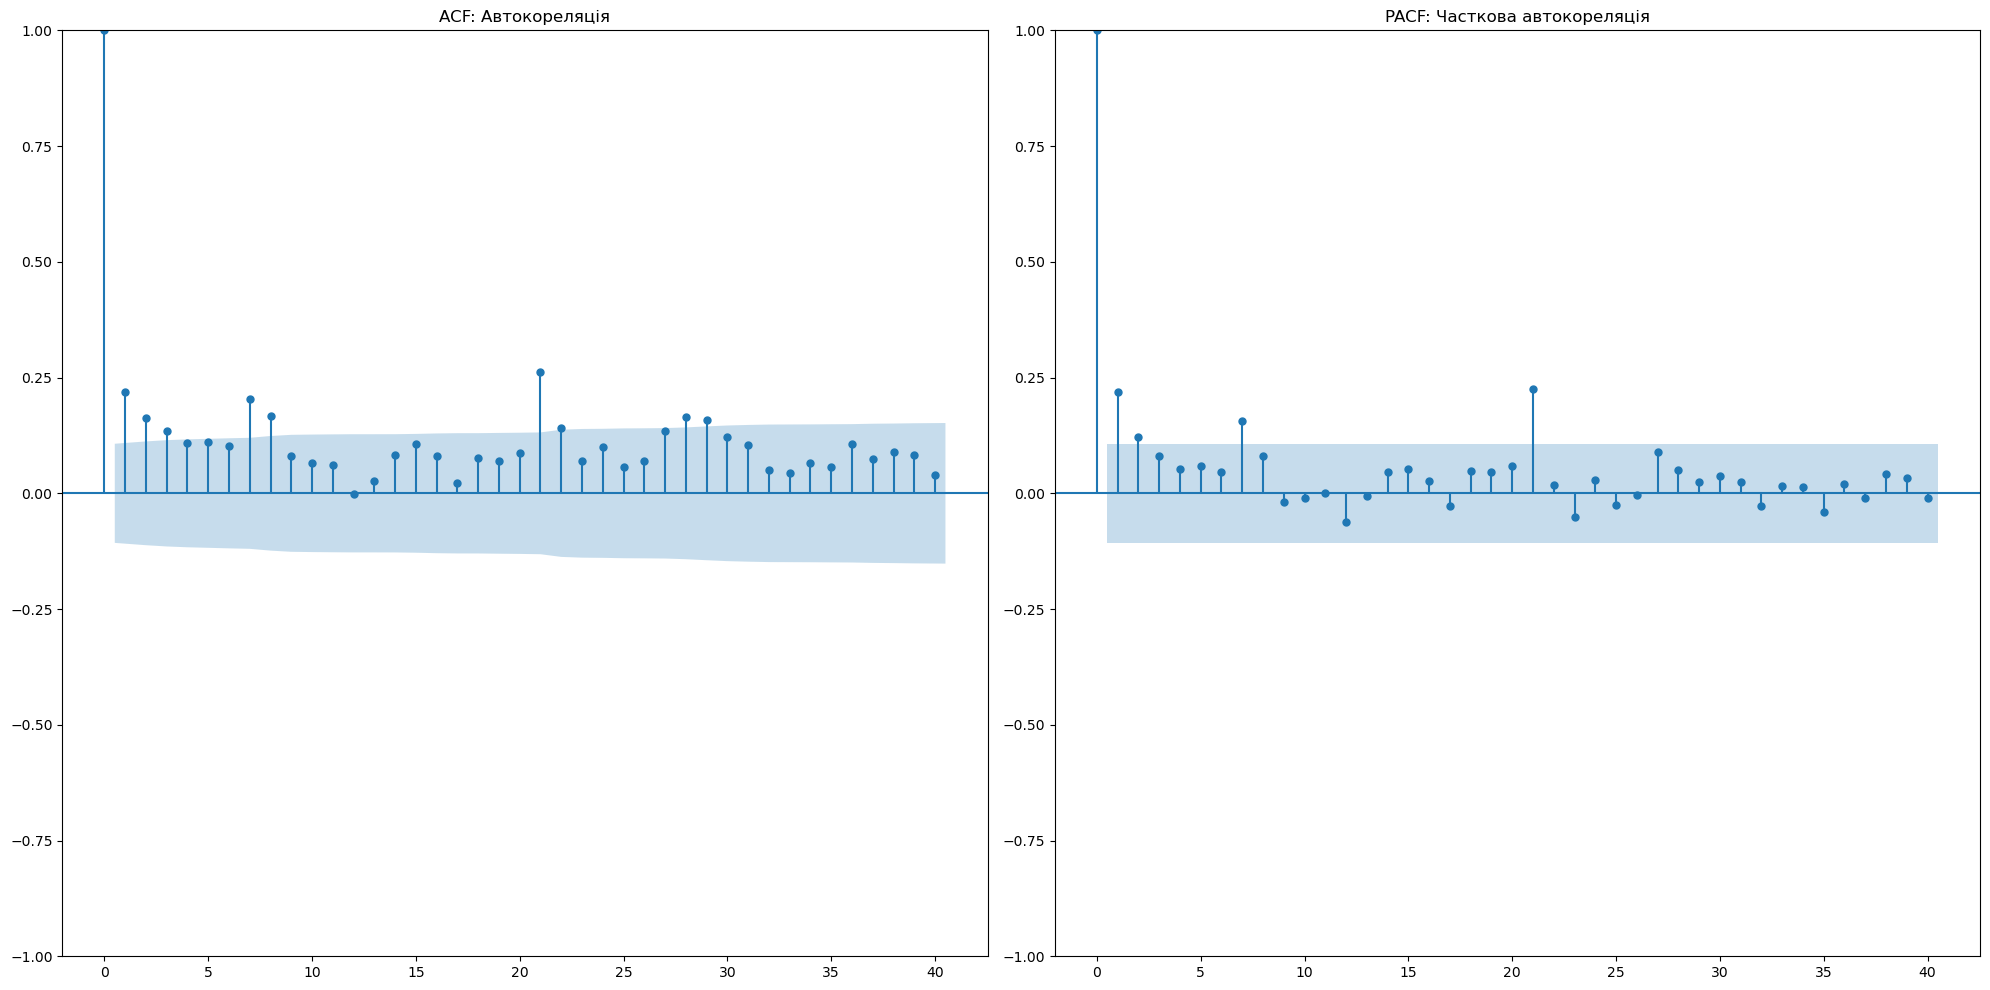

In [147]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plot_acf(births_train, lags=40, ax=plt.gca(), title='ACF: Автокореляція')

plt.subplot(1, 2, 2)
plot_pacf(births_train, lags=40, ax=plt.gca(), method='ywm', title='PACF: Часткова автокореляція')

plt.tight_layout()
plt.show()

PACF:
- кількість значимих лагів → значення p  -> 4
ACF:
- кількість значимих лагів → значення q -> 9
«Значимі» — стовпчики, які виходять за межі синіх ліній (довірчого інтервалу)

### Побудова моделей прогнозування:

- Побудуйте наступні моделі прогнозування:
- Модель Holt’s Winters (Triple Exponential Smoothing)
- ARIMA (AutoRegressive Integrated Moving Average)
- ARCH (Autoregressive Conditional Heteroskedasticity)
- Використовуйте GridSearchCV для підбору оптимальних параметрів моделей.

In [148]:
exponential_smoothing_model = ExponentialSmoothing(
    births_train,
    trend='add',
    seasonal='add',
    seasonal_periods= DAYS_IN_MONTH,
)

exponential_smoothing_model_fit = exponential_smoothing_model.fit()
exponential_smoothing_model_forecast = exponential_smoothing_model_fit.forecast(DAYS_IN_MONTH)

exponential_smoothing_model_forecast

array([48.19756775, 47.92183089, 48.55915051, 43.46875394, 43.74235324,
       48.01329434, 46.92284077, 44.555084  , 44.73724419, 43.46608509,
       46.37575624, 43.8296451 , 42.55777146, 46.92169947, 46.01178111,
       47.73954418, 49.10318765, 45.83074499, 46.64892495, 44.012762  ,
       47.83152272, 46.65099159, 45.01426716, 46.9240329 , 45.01472556,
       44.56966574, 44.15180647, 46.72779955, 43.73285357, 48.81706937])

Якщо p-value < 0.05 → ряд стаціонарний -> d = 0
Якщо p-value ≥ 0.05 → ряд нестаціонарний

In [152]:
result = adfuller(births_test, autolag='AIC')

print(f'ADF statistic: {result[0]}')
print(f'p-value: {result[1]}', result[1] < 0.05)

ADF statistic: -4.203632822420741
p-value: 0.0006496322854126157 True


In [162]:
arima_model = ARIMA(births_train, order=(4, 0, 9))

arima_model_fit = arima_model.fit()
arima_model_forecast = arima_model_fit.forecast(DAYS_IN_MONTH)

arima_model_forecast

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([43.668015  , 43.45935596, 43.70064497, 42.47542003, 41.50391925,
       43.05173555, 42.75559589, 41.36808053, 41.90616626, 42.55853829,
       41.56303473, 41.3463535 , 42.32125357, 42.10625903, 41.39884261,
       41.96452848, 42.36100052, 41.68929297, 41.64726233, 42.25445051,
       42.00266052, 41.57363727, 41.99042317, 42.17674114, 41.72181659,
       41.76786116, 42.15108016, 41.93451593, 41.69546075, 41.99782931])

In [165]:
print(arima_model_fit.mle_retvals)

{'fopt': 3.359558323502018, 'gopt': array([-6.39743813e-05, -2.43459919e-03,  1.48745900e-03,  4.48658177e-04,
        6.26156371e-04,  1.26682496e-03, -6.37706732e-04,  1.80740951e-03,
       -2.16130225e-04,  7.73349873e-04, -5.43549383e-04, -5.49658097e-06,
        2.58973554e-04,  3.07569792e-04, -8.76867379e-04]), 'fcalls': 896, 'warnflag': 1, 'converged': False, 'iterations': 50}


In [158]:
arch_model = arch_model_build(births_train, vol='GARCH', p=4, q=7)

arch_model_fit = arch_model.fit()
arch_model_forecast = arch_model_fit.forecast(horizon=DAYS_IN_MONTH)
arch_model_forecast_values = arch_model_forecast.variance.values[-1, :] 

arch_model_forecast_values

Iteration:      1,   Func. Count:     15,   Neg. LLF: 1202.8782345329223
Iteration:      2,   Func. Count:     31,   Neg. LLF: 1227.9473293562417
Iteration:      3,   Func. Count:     47,   Neg. LLF: 1164.9929745459249
Iteration:      4,   Func. Count:     62,   Neg. LLF: 1141.69402151872
Iteration:      5,   Func. Count:     76,   Neg. LLF: 1142.2601085206115
Iteration:      6,   Func. Count:     91,   Neg. LLF: 1141.5944394325008
Iteration:      7,   Func. Count:    105,   Neg. LLF: 1141.5789362394032
Iteration:      8,   Func. Count:    119,   Neg. LLF: 1141.5759862926488
Iteration:      9,   Func. Count:    133,   Neg. LLF: 1141.5754692798605
Iteration:     10,   Func. Count:    147,   Neg. LLF: 1141.5738865441194
Iteration:     11,   Func. Count:    161,   Neg. LLF: 1141.570504142985
Iteration:     12,   Func. Count:    175,   Neg. LLF: 1141.5622245155
Iteration:     13,   Func. Count:    189,   Neg. LLF: 1141.5476242005489
Iteration:     14,   Func. Count:    203,   Neg. LLF: 114

array([42.19265947, 55.93065943, 48.74957803, 43.79289788, 59.22154941,
       52.41606979, 45.39982674, 54.47170372, 50.42485656, 46.31202516,
       56.27352949, 52.77619248, 47.65410476, 53.57303059, 51.40787974,
       48.18150773, 54.55487574, 52.8894991 , 49.23085751, 53.04783936,
       51.97730261, 49.54370049, 53.58291131, 52.89776668, 50.33012447,
       52.7630835 , 52.30482734, 50.52273837, 53.05723718, 52.87040019])

### Побудова графіків прогнозів:

Побудуйте графіки прогнозів для кожної з моделей та порівняйте їх між собою.

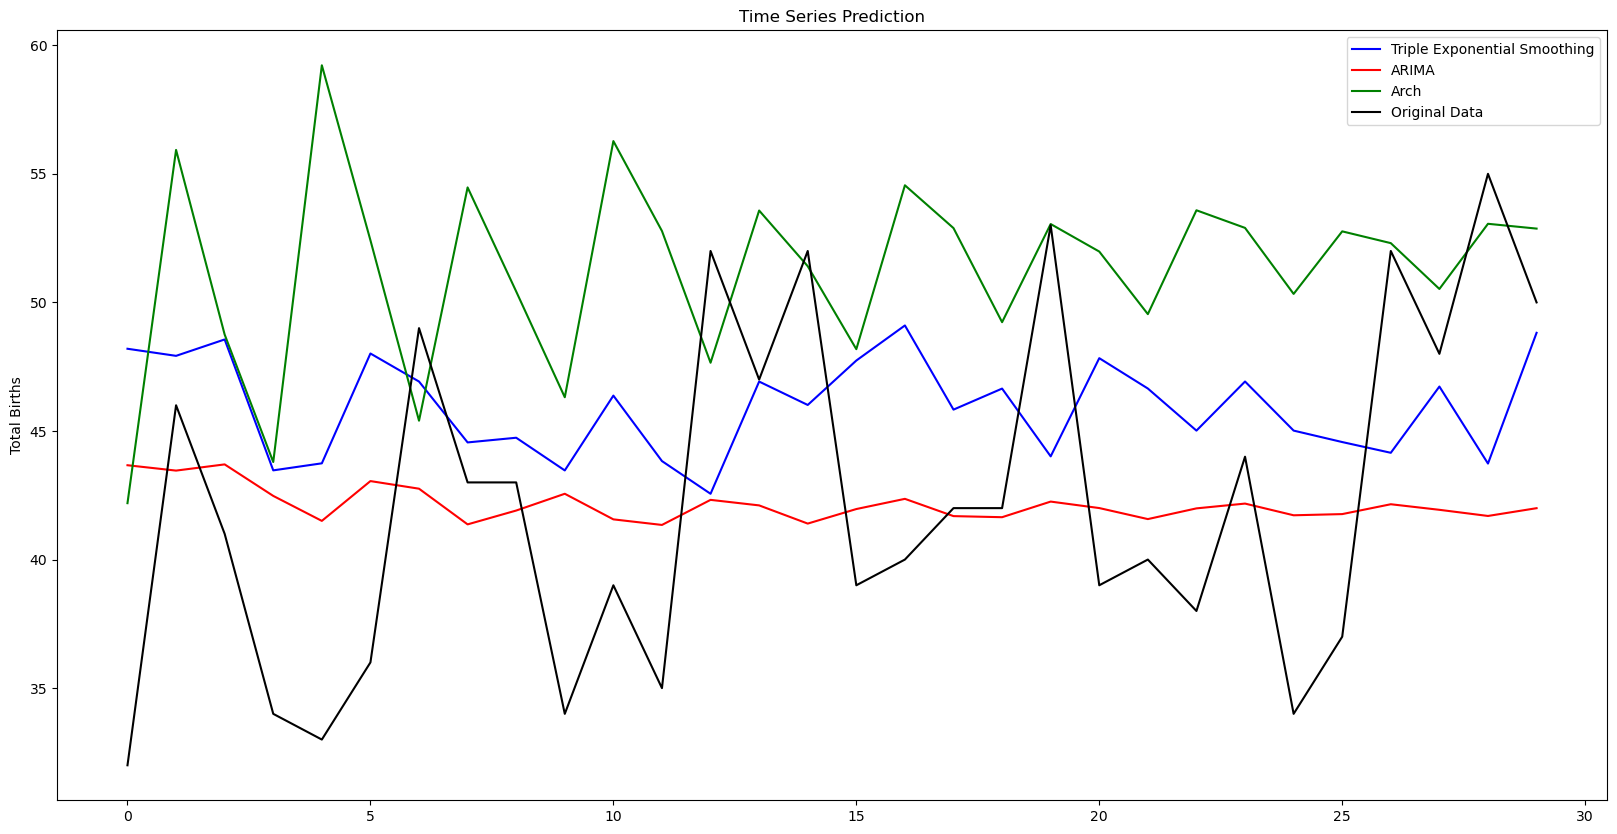

In [163]:
plt.figure(figsize=(20, 10))
plt.plot(exponential_smoothing_model_forecast, color='blue', label='Triple Exponential Smoothing')
plt.plot(arima_model_forecast, color='red', label='ARIMA')
plt.plot(arch_model_forecast_values, color='green', label='Arch')
plt.plot(births_test, color='black', label='Original Data')
plt.title('Time Series Prediction')
plt.ylabel('Total Births')
plt.legend()
plt.show()

### Порівняння точності моделей:

- Порівняйте точність побудованих моделей за допомогою відповідних метрик (наприклад, MSE, RMSE, MAE).
- Висновок про найбільш точну модель на основі результатів порівняння.

In [168]:
def evaluate_forecast(births_pred, model_name):
    mse = mean_squared_error(births_test, births_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(births_test, births_pred)

    print(f"{model_name} forecast accuracy:")
    print(f"MSE  = {mse:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"MAE  = {mae:.4f}")
    print()

In [169]:
evaluate_forecast(exponential_smoothing_model_forecast, "Exponential Smoothing")
evaluate_forecast(arima_model_forecast, "ARIMA")
evaluate_forecast(arch_model_forecast_values, "ARCH")

Exponential Smoothing forecast accuracy:
MSE  = 61.8595
RMSE = 7.8651
MAE  = 6.8446

ARIMA forecast accuracy:
MSE  = 45.1570
RMSE = 6.7199
MAE  = 5.6462

ARCH forecast accuracy:
MSE  = 130.8576
RMSE = 11.4393
MAE  = 9.6771

